<a href="https://colab.research.google.com/github/Sa1syo/NLTK/blob/main/IRNLP2019_Ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exersize 12. Information Retrieval 2

Exercise 11 and 12 are original contents of IR&NLP in Univ. of Aizu.  
Please read carefully in this page and try their source code.


Ex11では、Information Retrievalにおいて、IndexingとRetrievingについて学びました。  
Ex12では、Indexing後のRetrievingの高速化のために、転置インデックスの作成について学びます。  
また、PagelankとHits Algorithmについて学びます。

In Ex11, we learned about indexing and retrieving at Information Retrieval.   
In Ex12, we will learn about creating inverted indexes to speed up retrieving after indexing.  
Also we learn about Pagelank and Hits algorithm.

## Ex12.1 Inverted Index
nltkでは、Indexクラスを用いて、Indexingを行うことができます。この時に、直接単語索引を作ることができます。  
今回はGutenberg CorpusのKing Arthur and the Knights of the Round Tableを用いてみましょう。

NLTK has easy indexing tools as Index class. You can create a word index directly utilize Index class with stemming or lemmatizing easily.  
In this time, let's use Gutenberg Corpus's King Arthur and the Knights of the Round Table.

In [ ]:
import urllib.request

seedurl = "http://www.gutenberg.org/cache/epub/36462/pg36462.txt"
# For Python 3
seeddoc = urllib.request.urlopen(seedurl)
# For Python 2
#seeddoc = urllib.urlopen(seedurl)

# データがutf-8なので、utf8でデコードして読み込み
raw = seeddoc.read().decode('utf8')

In [ ]:
# 平文1000文字分を表示
raw[:1000]

'\ufeffThe Project Gutenberg EBook of King Arthur and the Knights of the Round\r\nTable, by Unknown\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: King Arthur and the Knights of the Round Table\r\n\r\nAuthor: Unknown\r\n\r\nEditor: Rupert S. Holland\r\n\r\nRelease Date: June 18, 2011 [EBook #36462]\r\n\r\nLanguage: English\r\n\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK KING ARTHUR--KNIGHTS ROUND TABLE ***\r\n\r\n\r\n\r\n\r\nProduced by Peter Vachuska, Dave Morgan, Mary Meehan and\r\nthe Online Distributed Proofreading Team at\r\nhttps://www.pgdp.net\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n                                 KING ARTHUR\r\n\r\n                     _and the Knights of the Round Table_\r\n\r\n                          EDITED BY RUPERT S. 

In [ ]:
import nltk, re, pprint
nltk.download('punkt')
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

# 多数改行する部分を捉えて、文としてピリオドを付与する
raw2 = re.sub(r'\r\n\r\n(\r\n)+', ".\r\n", raw)
raw2 = re.sub(r'\.\.', ".", raw2) # 上記作業でできた2重ピリオドを削除

# 入力したものを、文や単語ごとにトークン化
sentences = sent_tokenize(raw2)
tokens = word_tokenize(raw2)

print("Num. of Sentences: " + str(len(sentences)))
print("Num. of Words: " + str(len(tokens)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Num. of Sentences: 4046
Num. of Words: 121499


In [ ]:
# 100行分を表示。
for i in range(100,200):
    print(sentences[i])
    print("-----")

Malory's _Morte Darthur_ was not Tennyson's only source for the stories
of his Idylls.
-----
The adventures of Geraint he took from the _Mabinogion_,
a collection of mediæval Welsh tales translated with great charm and
accuracy by Lady Charlotte Guest, and published in 1838.
-----
Also, though to
a very limited extent, he drew some of his incidents from the history of
Geoffrey of Monmouth and the other early writers of chronicles.
-----
The great panorama of stories that we group together under the title of
_King Arthur and the Knights of the Round Table_, when they are told in
prose, are usually taken from Malory's book, the _Morte Darthur_,
condensed in size, for Malory was frequently verbose, and related in
more modern English.
-----
In this volume we have used as a basis the version
prepared by Sir James Knowles, which is an abridgment of Malory's work
as it was printed by Caxton, with a few additions from Geoffrey of
Monmouth and other sources.
-----
To this we have added the stor

- 文毎のInvert Indexの作成: 前回のLemmatizedTextを利用。  
We utilize previous LemmatizedText class for indexing and invert indexing.

In [ ]:
nltk.download('wordnet')
wnl = nltk.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from operator import itemgetter
# Wordnet Lemmatizerを用いてSentence単位のIndexing
class SentenceIndex(object):

    def __init__(self, lemmatizer, sentence):
        self._sentence = sentence
        self._lemmatizer = lemmatizer
        # Indexing
        self._index = nltk.Index((self._lemmatize(word), i)
                                 for (i, sentence) in enumerate(sentence)
                                 for word in word_tokenize(sentence))
        self._wdic = list((i,v,len(set(self._index[v])),len(self._index[v])) for (i, v) in enumerate(self._index))
        self._wpos = list((i,v,d,self._index[v].count(d)) for (i,v) in enumerate(self._index) for d in set(self._index[v]))
        # Invert Indexing
        self._rindex = nltk.Index((k, j) for (j, v) in enumerate(self._index) for k in self._index[v])
        sorted(self._rindex)

    def search(self, query, resnum=5):
        cnt = [0] * len(self._sentence)
        qlist = list(self._lemmatize(w) for w in word_tokenize(query))
        for q in qlist:
            for s in self._index[q]:
                cnt[s] += 1
        
        searchlist = list((i,v) for (i,v) in enumerate(cnt))
        searchlist = sorted(searchlist, key=itemgetter(1), reverse=True)
        
        for j, r in enumerate(searchlist):
            if j < resnum:
                print(self._sentence[r[0]])
        print(searchlist[:20])

    def _lemmatize(self, word):
        return self._lemmatizer.lemmatize(word).lower()

In [ ]:
wnl = nltk.WordNetLemmatizer()
sin = SentenceIndex(wnl, sentences)

In [ ]:
# ある単語がどの文に含まれているかのリスト (Index)
for i, s in enumerate(sin._index):
    if i > 100 and i < 110:
        print((s,sin._index[s]))

('said', [7, 88, 136, 140, 143, 145, 147, 167, 181, 183, 184, 184, 212, 213, 214, 228, 235, 236, 237, 244, 253, 259, 261, 269, 272, 274, 281, 282, 283, 285, 289, 313, 317, 318, 321, 324, 325, 326, 328, 329, 330, 345, 360, 372, 376, 380, 386, 387, 390, 404, 430, 431, 433, 435, 437, 438, 440, 441, 445, 447, 449, 450, 452, 453, 454, 456, 457, 458, 477, 501, 502, 502, 503, 505, 506, 508, 509, 511, 515, 517, 518, 523, 524, 526, 529, 530, 534, 539, 540, 545, 550, 555, 558, 574, 576, 585, 591, 629, 630, 636, 638, 639, 642, 644, 648, 654, 655, 660, 662, 664, 665, 668, 670, 671, 672, 673, 674, 675, 676, 677, 679, 685, 688, 690, 691, 693, 694, 700, 707, 709, 713, 726, 728, 734, 739, 740, 742, 744, 746, 754, 770, 771, 773, 774, 779, 783, 784, 787, 792, 793, 796, 805, 807, 813, 819, 821, 823, 826, 829, 830, 842, 844, 849, 853, 855, 857, 860, 862, 867, 868, 869, 872, 891, 893, 895, 900, 903, 904, 906, 909, 910, 914, 915, 916, 923, 932, 936, 941, 948, 955, 956, 960, 968, 969, 970, 973, 985, 986, 988

In [ ]:
# 単語がどれくらいのドキュメントにいくら含まれているかのリスト (Dictionary)
for i, s in enumerate(sin._wdic):
    if i > 100 and i < 150:
        print(s)

(101, 'said', 923, 927)
(102, 'she', 298, 395)
(103, 'made', 169, 171)
(104, 'most', 61, 62)
(105, 'part', 43, 43)
(106, 'mine', 37, 37)
(107, 'own', 100, 104)
(108, 'hair', 5, 5)
(109, 'which', 166, 173)
(110, 'while', 82, 85)
(111, 'i', 834, 1269)
(112, 'wa', 690, 815)
(113, 'yet', 127, 131)
(114, 'world', 72, 72)
(115, 'loved', 25, 26)
(116, 'full', 135, 138)
(117, 'well', 149, 152)
(118, 'introduction', 3, 3)
(119, '!', 247, 248)
(120, 'what', 157, 163)
(121, 'magic', 8, 8)
(122, 'word', 69, 71)
(123, 'how', 73, 94)
(124, 'they', 563, 729)
(125, 'carry', 10, 10)
(126, 'u', 82, 88)
(127, 'straight', 17, 17)
(128, 'to', 1757, 2452)
(129, 'day', 181, 188)
(130, 'chivalry', 9, 9)
(131, 'witchcraft', 4, 4)
(132, 'merlin', 100, 106)
(133, 'wonderful', 3, 3)
(134, 'deed', 45, 46)
(135, 'lancelot', 374, 393)
(136, 'perceval', 6, 8)
(137, 'galahad', 94, 98)
(138, 'quest', 39, 40)
(139, 'holy', 45, 46)
(140, 'grail', 16, 17)
(141, 'all', 701, 781)
(142, 'that', 1031, 1211)
(143, 'glorious', 

In [ ]:
# 単語がどれくらい、どのドキュメントにいくら含まれているかのリスト (Posting)
for i, s in enumerate(sin._wdic):
    if i > 100 and i < 150:
        print(s)

(101, 'said', 923, 927)
(102, 'she', 298, 395)
(103, 'made', 169, 171)
(104, 'most', 61, 62)
(105, 'part', 43, 43)
(106, 'mine', 37, 37)
(107, 'own', 100, 104)
(108, 'hair', 5, 5)
(109, 'which', 166, 173)
(110, 'while', 82, 85)
(111, 'i', 834, 1269)
(112, 'wa', 690, 815)
(113, 'yet', 127, 131)
(114, 'world', 72, 72)
(115, 'loved', 25, 26)
(116, 'full', 135, 138)
(117, 'well', 149, 152)
(118, 'introduction', 3, 3)
(119, '!', 247, 248)
(120, 'what', 157, 163)
(121, 'magic', 8, 8)
(122, 'word', 69, 71)
(123, 'how', 73, 94)
(124, 'they', 563, 729)
(125, 'carry', 10, 10)
(126, 'u', 82, 88)
(127, 'straight', 17, 17)
(128, 'to', 1757, 2452)
(129, 'day', 181, 188)
(130, 'chivalry', 9, 9)
(131, 'witchcraft', 4, 4)
(132, 'merlin', 100, 106)
(133, 'wonderful', 3, 3)
(134, 'deed', 45, 46)
(135, 'lancelot', 374, 393)
(136, 'perceval', 6, 8)
(137, 'galahad', 94, 98)
(138, 'quest', 39, 40)
(139, 'holy', 45, 46)
(140, 'grail', 16, 17)
(141, 'all', 701, 781)
(142, 'that', 1031, 1211)
(143, 'glorious', 

In [ ]:
# ある文にどの単語が含まれているかのリスト (Inverted Index)
for i, s in enumerate(sin._rindex):
    if i > 100 and i < 150:
        print((i,sin._rindex[s]))

(101, [4, 4, 4, 4, 4, 7, 7, 8, 8, 8, 8, 12, 12, 28, 92, 92, 128, 147, 147, 147, 157, 186, 188, 284, 297, 392, 421, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625])
(102, [4, 4, 4, 7, 8, 8, 8, 12, 21, 28, 84, 128, 128, 147, 151, 170, 231, 284, 289, 302, 324, 340, 390, 450, 615, 626, 627, 628, 629, 630, 631, 632, 633, 634])
(103, [4, 5, 6, 7, 7, 8, 21, 24, 24, 28, 92, 112, 123, 156, 174, 280, 284, 284, 308, 367, 629, 635, 636, 637, 638])
(104, [4, 4, 8, 8, 12, 12, 12, 28, 128, 128, 147, 147, 147, 151, 162, 205, 250, 284, 325, 371, 385, 401, 433, 449, 639, 640, 641, 642, 643])
(105, [4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 8, 12, 12, 12, 28, 103, 118, 128, 132, 147, 147, 147, 151, 156, 250, 284, 287, 319, 357, 445, 500, 518, 648, 649, 650, 651, 652, 653])
(106, [4, 4, 4, 6, 7, 8, 8, 12, 12, 24, 28, 128, 142, 142, 147, 147, 156, 173, 188, 192, 222, 250, 253, 284, 427, 450, 507, 544, 599, 654, 655, 656, 657])
(107, [4, 4, 4, 6, 7, 7, 8, 8, 12, 28, 103, 147, 151, 151, 163, 201, 

In [ ]:
# 用いたSearch例: 関数は上記ソースコードに記載。
q = "King Arthur, Sir Lancelot and Queen Guinevere"
sin.search(q)

And on King Arthur's side there came the King of Ireland and the King of
Scotland, the noble prince Sir Galahaut, Sir Gawain and his brothers Sir
Agravain and Sir Gaheris, Sir Ewaine, Sir Tor, Sir Perceval, and Sir
Lamoracke, Sir Lancelot also and his kindred, Sir Lionel, Sir Ector, Sir
Bors and Sir Bedivere, likewise Sir Key and the most part of the Table
Round.
So the
queen often sent for him, and bade him tell of his birth and strange
adventures: how he was only son of great King Ban of Brittany, and how,
one night, his father, with his mother Helen and himself, fled from his
burning castle; how his father, groaning deeply, fell to the ground and
died of grief and wounds, and how his mother, running to her husband,
left himself alone; how, as he thus lay wailing, came the lady of the
lake, and took him in her arms and went with him into the midst of the
waters, where, with his cousins Lionel and Bors, he had been cherished
all his childhood until he came to King Arthur's court; and 

## 12.2. Web Crawling and Link Analysis

次に、Webデータのクローラーと、リンク解析を行ってみましょう。  
下記のコードは、会津大学のWebデータを取得するクローラーです。  
なお、Webクローリングは、他のサーバーに非常に大きい負荷を掛けるので、  
演習中に動作させないようにお願いいたします。

In [ ]:
from html.parser import HTMLParser
from urllib.request import urlopen
from urllib.parse import urljoin
import re
import time

# Constructing original parser
class MyHTMLParser(HTMLParser):

    # link list from each page
    urllist = []
    # class value
    current = None
    root = None
    
    # Parsing and extract url including a page
    def handle_starttag(self, tag, attrs):
        if tag == 'a':
            u = dict(attrs).get('href')
            # to find direct link, relative link or non-web page
            if re.match("^http.*", u):
                pass # start pattern is http,,, is OK.
            elif re.match("^(mailto|tel).*",u):
                return # start pattern is other protocol is not accepted
            else:
                u = urljoin(self.current, u) # the other patten is maybe relative.
            # find internal link -> expire
            if re.match(".*\#.*", u):
                return
            # find media file -> expire
            if re.match(".*(pdf|jpg|zip)", u):
                return
            # adding url only same domain
            if u.startswith(self.root):
                self.urllist.append(u)

    # root url
    def setroot(self, root):
        self.root = root

    # current url
    def setcurrent(self, current):
        self.current = current
    
    # URL list output
    def geturllist(self):
        return self.urllist

visitlist = []
candlist = ['http://u-aizu.ac.jp']
count = 0
seed = 'http://u-aizu.ac.jp'
while candlist:
    count += 1
    u = candlist.pop(0)
    print(u)
    try:
        f = urlopen(u)
        visitlist.append(u)
        parser = MyHTMLParser()
        parser.setroot(seed)
        parser.setcurrent(u)
        parser.feed(f.read().decode('utf-8'))
        candlist += parser.geturllist()
        candlist = list( s for s in candlist if s not in visitlist)
        candlist = sorted(set(candlist), key=candlist.index)
        #print(candlist)
    except:
        print('Not Found: ', u)
    if count > 100:
        break
    time.sleep(0.1)

http://u-aizu.ac.jp
http://u-aizu.ac.jp/
http://u-aizu.ac.jp/access/
http://u-aizu.ac.jp/sitemap/
http://u-aizu.ac.jp/inquiry/
http://u-aizu.ac.jp/prospective/
http://u-aizu.ac.jp/alumni/
http://u-aizu.ac.jp/public/
http://u-aizu.ac.jp/current/
http://u-aizu.ac.jp/intro/
http://u-aizu.ac.jp/curriculum/
http://u-aizu.ac.jp/admissions/
http://u-aizu.ac.jp/campus/
http://u-aizu.ac.jp/career/
http://u-aizu.ac.jp/graduate/
http://u-aizu.ac.jp/research/
http://u-aizu.ac.jp/materials/
http://u-aizu.ac.jp/research/field/network/index.html
http://u-aizu.ac.jp/research/field/system/index.html
http://u-aizu.ac.jp/research/field/space/index.html
http://u-aizu.ac.jp/research/field/programming/index.html
http://u-aizu.ac.jp/research/field/environment/index.html
http://u-aizu.ac.jp/research/field/robot/index.html
http://u-aizu.ac.jp/research/field/brain/index.html
http://u-aizu.ac.jp/research/field/software/index.html
http://u-aizu.ac.jp/research/field/art/index.html
http://u-aizu.ac.jp/research/fiel

上記のパーサーは、Seedとなっているhttp://www.u-aizu.ac.jp ドメイン以下のページアドレスを収集してくるものです。  
The above parser collects page addresses under the http://www.u-aizu.ac.jp domain which is a seed.

もし、ページの内容を取得して検索したい場合は、各アドレスに訪れた際に取得するraw HTMLデータをパージングし、目的の形にしてテキストに保存することによって可能となります。  
If you want to retrieve the contents of a page and search it, you can do so by parsing the raw HTML data you get when you visit each address, saving it in text in the desired form.

また、リンク解析を行う場合は、同様に既に収集されたアドレスにIDを付与し、そのアドレスからリンクが張られているアドレスのIDのリストを取得するようにすれば、リンクリストを取得できますので、リンク解析を行うことができます。  
Also, when performing link analysis, you can also obtain a link list by assigning an ID to the already collected addresses and obtaining a list of IDs of the linked addresses from that address so you can do a link analysis.

以下のコードは、リンク解析の1つで、どのような構造でリンクが接続されているのかを見るサンプルコードです。  
The following code is one example of link analysis, and is sample code that shows how links are connected in a structure.

Unmatch!
Match!
2 / 97
Unmatch!
Unmatch!
Unmatch!
Match!
6 / 97
被リンク！https:--www.u-aizu.ac.jp-en- -> -
被リンク！https:--www.u-aizu.ac.jp-en- -> -
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--twitter.com-univ_aizu
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--www.facebook.com-univaizu-
被リンク！https:--www.u-aizu.ac.jp-en- -> http:--line.naver.jp-ti-p-%40u-aizu
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--www.youtube.com-user-univaizu
被リンク！https:--www.u-aizu.ac.jp-en- -> http:--www.ubic-u-aizu.jp-intl.it-
被リンク！https:--www.u-aizu.ac.jp-en- -> http:--web-ext.u-aizu.ac.jp-pc-concours-
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--rtc-fukushima.jp-
被リンク！https:--www.u-aizu.ac.jp-en- -> #head
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--twitter.com-univ_aizu
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--www.facebook.com-univaizu-
被リンク！https:--www.u-aizu.ac.jp-en- -> http:--line.naver.jp-ti-p-%40u-aizu
被リンク！https:--www.u-aizu.ac.jp-en- -> https:--www.youtube.com-user-univaizu
被リンク！https:--www.u-aizu.ac.j

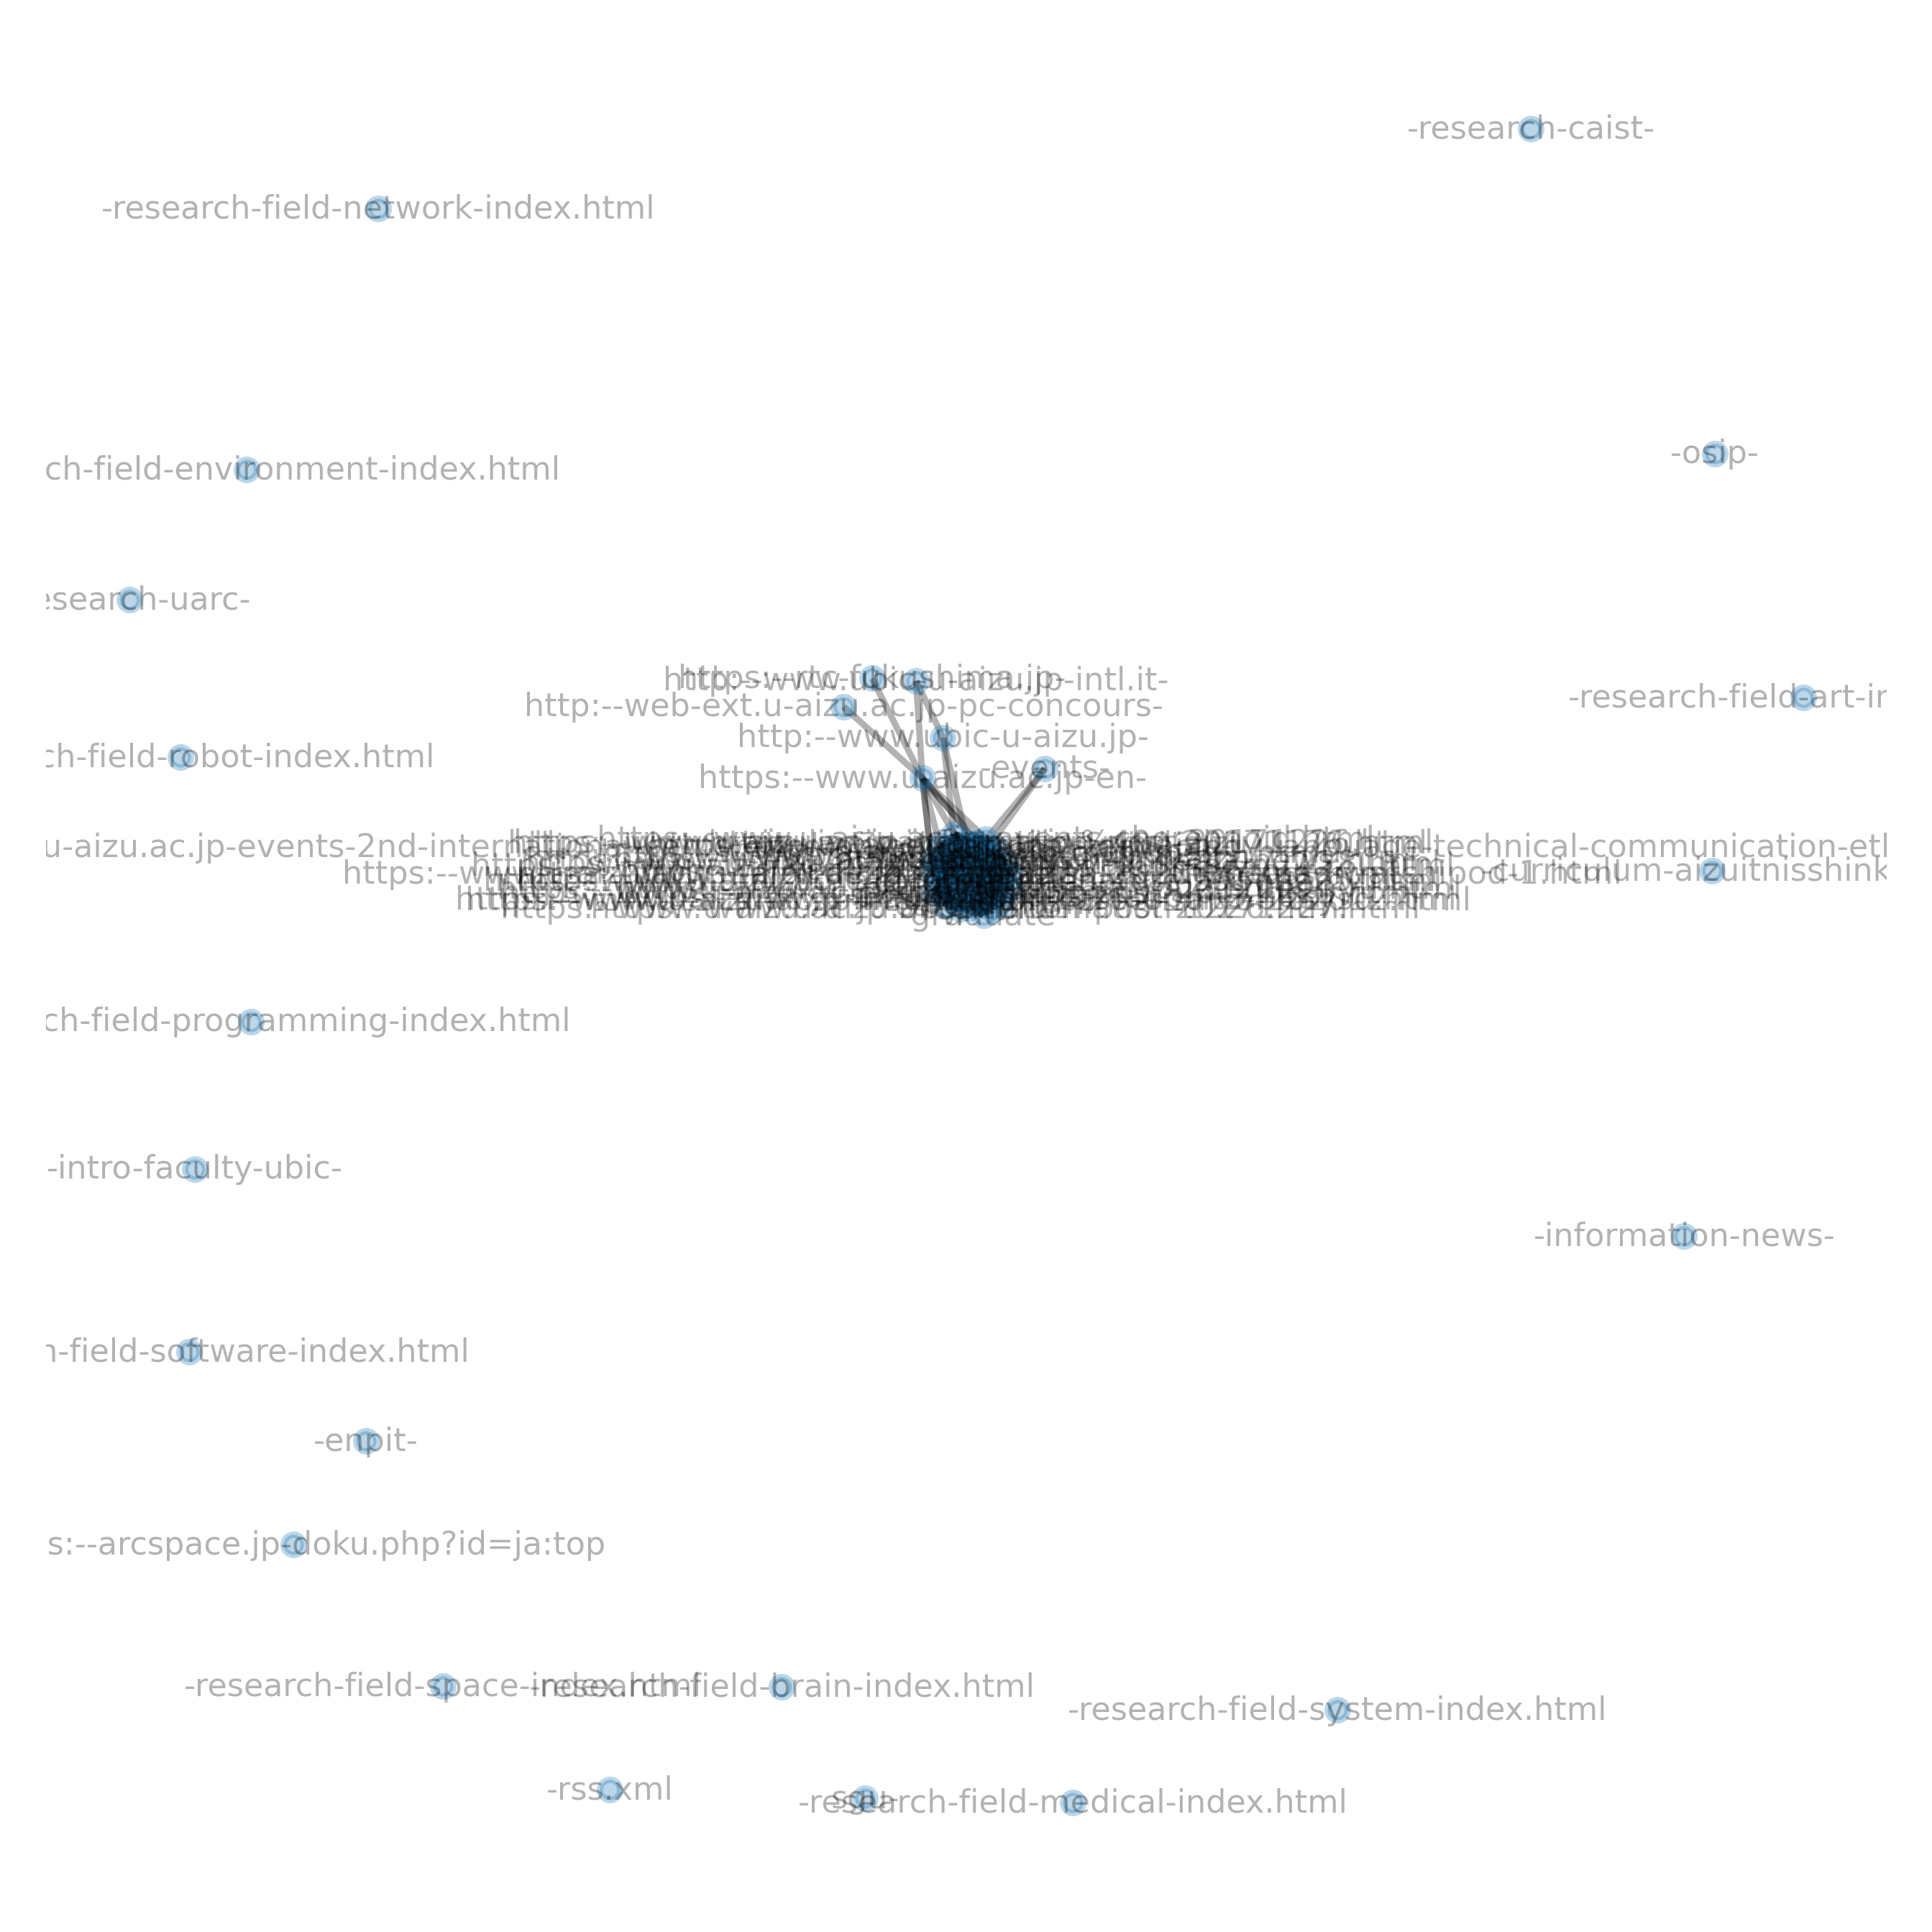

In [ ]:
from bs4 import BeautifulSoup
import urllib
from urllib import request
import time
import csv
import os
import numpy as np
from argparse import ArgumentParser
import networkx as nx
import matplotlib.pyplot as plt
 
def extract_url(root_url):
    page = 1
    is_articles = True
    urls = []
    
    while is_articles:
        html = request.urlopen(root_url)
        soup = BeautifulSoup(html, "html.parser")
        articles = soup.find_all("a")
        for article in articles:
            urls.append(article.get("href"))
        is_articles = False
        
        page += 1
    return urls
 
def make_network(root_url, urls):
    entry_url = root_url
    G = nx.Graph()
    for url in urls:
        article_name= url.replace(entry_url,"").replace("/","-")
        G.add_node(article_name)
    for i,url in enumerate(urls):
        if url.startswith("http"):
            print("Match!")
        else:
            print("Unmatch!")
            continue
        print(i+1,"/",len(urls))
        try:
            html = request.urlopen(url)
        except urllib.error.HTTPError as e: 
            print(e.reason)
        except urllib.error.URLError as e: 
            print(e.reason)
        soup = BeautifulSoup(html, "html.parser")
        links = soup.find_all("a")
        for link in links:
            l = link.get("href")
            if l in urls:
                linking_article_name = url.replace(entry_url,"").replace("/","-")
                linked_article_name = l.replace(entry_url,"").replace("/","-")
                print("被リンク！{} -> {}".format(linking_article_name, linked_article_name))
                j = urls.index(l)
                G.add_edge(linking_article_name, linked_article_name)
            else: 
                continue
    return G
 
def visualize(G, savename, savegml):
    pos = nx.spring_layout(G) # グラフ形式を選択。ここではスプリングモデルでやってみる
    plt.figure(figsize=(4, 4), dpi=640)
    nx.draw(G, pos, with_labels=True,alpha=0.3,font_size=5.0,node_size=10) # グラフ描画。 オプションでノードのラベル付きにしている
    plt.savefig(savename+".png")
    plt.show()
    if savegml:
        nx.write_gml(G,savename+".gml")
 
    
urls = extract_url('http://www.u-aizu.ac.jp')
G = make_network('http://www.u-aizu.ac.jp', urls)
visualize(G, 'uaizu', 'uaizu')

## 12.3. Page Rank and HITS

講義では、PageRankやHITS Algorithmの理論を勉強しましたが、実際にPageRankやHITSを扱う場合は、既に実装されているアルゴリズムを利用するのがより正確に便利に利用できると思います。
NetworkXは、ネットワーク解析周りのアルゴリズムを提供します。特に、ネットワーク解析で使う、ノードやエッジの書き方や、トラバースの仕方、PagerankやHITSが既に実装してあるので、以下の通りそのまま使うことができます。

In the lecture, we studied the theory of PageRank and HITS Algorithm, but when actually dealing with PageRank and HITS, it is more accurate and convenient to use the already implemented algorithm. NetworkX provides algorithms for network analysis. In particular, the method of writing nodes and edges used in network analysis, the method of traversing the graph, Pagerank and HITS are already implemented. Just you can use them as follows.

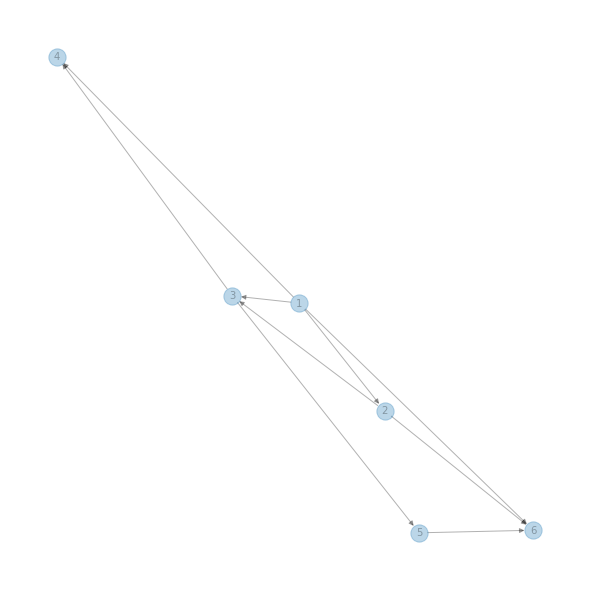

-----pagerank-----
{1: 0.09239221032272713, 2: 0.11202546652062978, 3: 0.1596362278548462, 4: 0.1798708491907905, 5: 0.1602375929928878, 6: 0.29583765311811816}
-----pagerank(numpy)-----
{1: 0.09239208559289434, 2: 0.11202540378138438, 3: 0.1596362003884726, 4: 0.17987078894648503, 5: 0.16023747075799513, 6: 0.29583805053276846}
Hub:  {1: 0.45299695551094027, 2: 0.2769098145940095, 3: 0.11862271833110173, 4: 0.0, 5: 0.1514705115639485, 6: 0.0}
Authority:  {1: 0.0, 2: 0.16445565698754805, 3: 0.2649847770121012, 4: 0.20752035566128968, 5: 0.043064698673741617, 6: 0.3199745116653195}


In [ ]:
# -*- coding: utf-8 -*-
import networkx as nx
import matplotlib.pyplot as plt

#有向グラフのインスタンスを生成
g = nx.DiGraph()

#ノードを追加する ※ソーシャルグラフなら人がノードになることが多い
g.add_node(1)
g.add_node(2)
g.add_node(3)                                                                                                                     
g.add_node(4)
g.add_node(5)
g.add_node(6)
#分かりやすいように敢えての羅列形式

#ノード間の矢印を加えていく ※ソーシャルグラフなら友達関係やフォロー、いいね！など
g.add_edge(1,2)
g.add_edge(1,3)
g.add_edge(1,4)
g.add_edge(2,3)
g.add_edge(3,4)
g.add_edge(3,5)
g.add_edge(2,6)
g.add_edge(5,6)
g.add_edge(1,6)
#分かりやすいように敢えての羅列形式

#pagerank値の計算
pr=nx.pagerank(g,alpha=0.85)

#pagerank値の計算(numpyを利用)
prn=nx.pagerank_numpy(g,alpha=0.85)

# For printing graph
plt.figure(figsize=(8,8))
nx.draw(g ,with_labels=True,alpha=0.3,font_size=10.0,node_size=300)
plt.show()

#計算結果表示
print("-----pagerank-----")
print(pr)

print("-----pagerank(numpy)-----")
print(prn)

h,a=nx.hits(g)
print("Hub: ",h)
print("Authority: ",a)

# Trial

Please make your own graph pattern with 7 nodes and calculate PageRank and HITS algorithm using above source code.

{0: 0.025604998149225188, 1: 0.021927135681819733, 2: 0.009133632149187906, 3: 0.013783158594119233, 4: 0.005227705175339628, 5: 0.009524675076016974, 6: 0.02091440865538257, 7: 0.017565788921040743, 8: 0.005127566408012146, 9: 0.009563214929670395, 10: 0.013578696706151801, 11: 0.025704173037830562, 12: 0.02197593936515417, 13: 0.010193489077468972, 14: 0.013993327432932294, 15: 0.018725212961989382, 16: 0.005347803854754353, 17: 0.01565382637191133, 18: 0.014042467114497553, 19: 0.022496838698313294, 20: 0.005127566408012146, 21: 0.005478534711259112, 22: 0.009810239434036479, 23: 0.005232528210837097, 24: 0.0097630759578097, 25: 0.010572619088647626, 26: 0.010046152400649445, 27: 0.014943794365073204, 28: 0.014672210234344871, 29: 0.010180377774740235, 30: 0.020721271419370742, 31: 0.015014362051912832, 32: 0.01, 33: 0.010046152400649445, 34: 0.00576912404679044, 35: 0.014182116804722363, 36: 0.010634327435254293, 37: 0.0059356485216582495, 38: 0.014798929020061073, 39: 0.0109100296

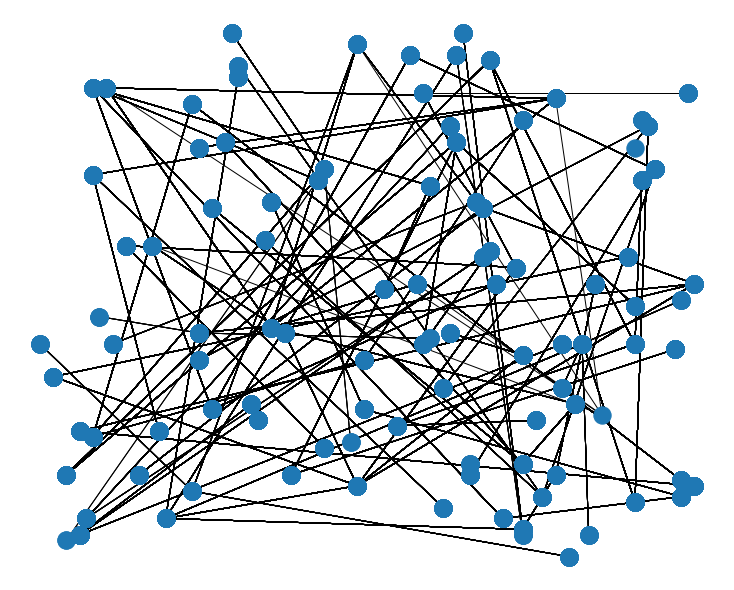

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import networkx as nx
import random

#ネットワーク
g = nx.Graph()
def get_fig(node_number):                                                                                                         
    g.add_node(node_number, Position=(random.randrange(0, 100), random.randrange(0, 100)))
    #print(random.choice(g.nodes()))
    g.add_edge(node_number, random.choice(list(g.nodes())))
    nx.draw(g, pos=nx.get_node_attributes(g,'Position'))
    
fig = plt.figure(figsize=(10,8))
anim = animation.FuncAnimation(fig, get_fig, frames=100)

anim.save('graph_gifani.gif', writer='pillow', fps=10);

pr=nx.pagerank(g,alpha=0.85)
print(pr)

Hub:  {0: 0.1909830056647784, 1: 0.3090169943352216, 2: 0.3090169943352216, 3: 0.1909830056647784}
Authority:  {0: 0.190983005521049, 1: 0.309016994478951, 2: 0.309016994478951, 3: 0.190983005521049}


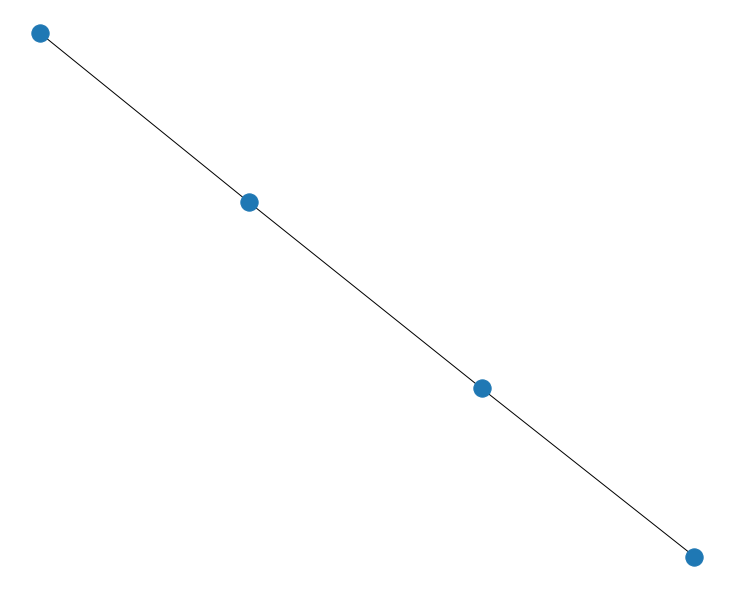

In [ ]:
G=nx.path_graph(4)
fig = plt.figure(figsize=(10,8))
nx.draw(G)
h,a=nx.hits(G)
print("Hub: ",h)
print("Authority: ",a)